dataset: Salesforce/wikitext/wikitext-103-raw-v1

model: pythia

In [1]:
%load_ext autoreload
%autoreload 2


import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('..')

import pickle

import torch
import datasets
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [2]:
model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128
N_mem_tokens = 1

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [34]:
from pathlib import Path
load_path = Path(f'./runs/{model_name}/mem_{N_mem_tokens}_len_{max_length}.pkl')
results_50_texts = pickle.load(open(load_path, 'rb'))

results_samples = []

for i in range(0, 9):
    load_path = Path(f'./runs/{model_name}/mem_{N_mem_tokens}_len_{max_length}_sample_{i}.pkl')
    results_samples += [pickle.load(open(load_path, 'rb'))]

In [35]:
import numpy as np
mems_50_texts = []
for res in results_50_texts:
    mems_50_texts += [res['best_memory_params']]
mems_50_texts = np.concatenate(mems_50_texts, axis=0)

print(mems_50_texts.shape)

mems_texts = []
for i in range(0, 9):
    mems_sample = []
    for res in results_samples[i]:
        mems_sample  += [res['best_memory_params']]
    mems_sample = np.concatenate(mems_sample, axis=0)
    mems_texts += [mems_sample]
    print(i, mems_sample.shape)

(50, 2048)
0 (50, 2048)
1 (50, 2048)
2 (50, 2048)
3 (50, 2048)
4 (50, 2048)
5 (50, 2048)
6 (50, 2048)
7 (50, 2048)
8 (50, 2048)


In [36]:
model = AutoModelForCausalLM.from_pretrained(model_name)
embs = model.get_input_embeddings().weight.data.numpy()
embs.shape

(32000, 2048)

In [37]:
from sklearn.decomposition import PCA

n_components = 3
# pca = PCA(n_components=n_components).fit(np.concatenate([all_mems[:25], embs[:16000], all_mems_0[:25], all_mems_1[:25]], axis=0))
pca = PCA(n_components=n_components).fit(np.concatenate([mems_50_texts] +  # embs,
                                                        mems_texts, axis=0))
# pca = PCA(n_components=n_components).fit(embs)

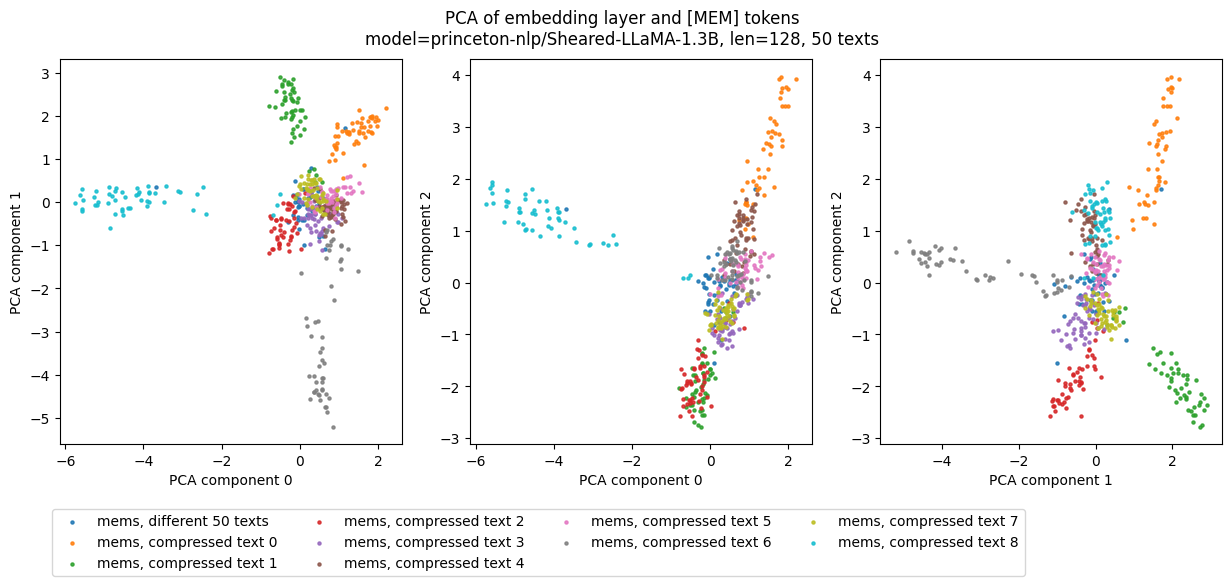

In [38]:
import matplotlib.pyplot as plt

mems_50_texts_pca = pca.transform(mems_50_texts)
mems_texts_pca = []
for mems_text in mems_texts:
    mems_texts_pca += [pca.transform(mems_text)]   
        
# embs_pca = pca.transform(embs)

dot_size = 5
alpha = 0.85

# colors = plt.cm.tab10(np.linspace(0, 1, 15))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(mems_50_texts_pca[:,0], mems_50_texts_pca[:,1], label='mems, different 50 texts', s=dot_size, alpha=alpha)
for i, mems_text_pca in enumerate(mems_texts_pca):
    plt.scatter(mems_text_pca[:,0], mems_text_pca[:,1], label=f'mems, compressed text {i}', s=dot_size, alpha=alpha)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

plt.subplot(1, 3, 2)
plt.scatter(mems_50_texts_pca[:,0], mems_50_texts_pca[:,2], label='mems, different 50 texts', s=dot_size, alpha=alpha)
for i, mems_text_pca in enumerate(mems_texts_pca):
    plt.scatter(mems_text_pca[:,0], mems_text_pca[:,2], label=f'mems, compressed text {i}', s=dot_size, alpha=alpha)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 2')

plt.subplot(1, 3, 3)
plt.scatter(mems_50_texts_pca[:,1], mems_50_texts_pca[:,2], label='mems, different 50 texts', s=dot_size, alpha=alpha)
for i, mems_text_pca in enumerate(mems_texts_pca):
    plt.scatter(mems_text_pca[:,1], mems_text_pca[:,2], label=f'mems, compressed text {i}', s=dot_size, alpha=alpha)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')

plt.suptitle(f'PCA of embedding layer and [MEM] tokens\nmodel={model_name}, len={max_length}, 50 texts')
plt.legend(loc='upper center', bbox_to_anchor=(-1.0, -0.15), ncol=4)
plt.show()

In [39]:
import umap
n_components = 3
umap = umap.UMAP(n_components=n_components).fit(np.concatenate([mems_50_texts] +  #embs[:500],
                                                                mems_texts, axis=0))

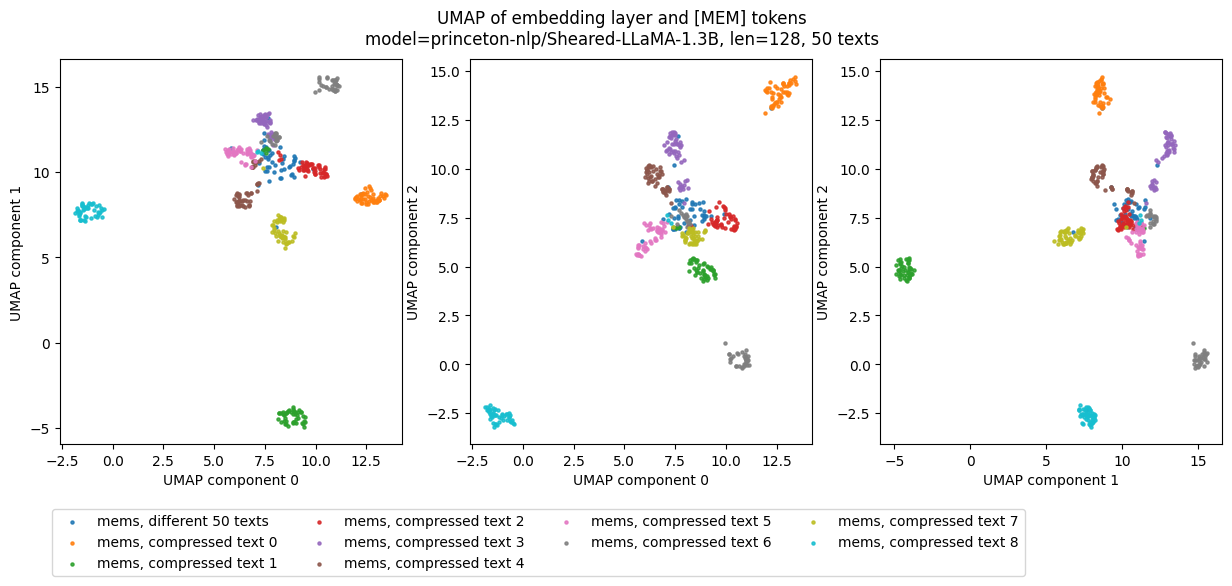

In [52]:
import matplotlib.pyplot as plt

mems_50_texts_umap = umap.transform(mems_50_texts)
mems_texts_umap = []
for mems_text in mems_texts:
    mems_texts_umap += [umap.transform(mems_text)]
# embs_umap = umap.transform(embs[:500])

dot_size = 5
alpha = 0.85

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(mems_50_texts_umap[:,0], mems_50_texts_umap[:,1], label='mems, different 50 texts', s=dot_size, alpha=alpha)
for i, mems_text_umap in enumerate(mems_texts_umap):
    plt.scatter(mems_text_umap[:,0], mems_text_umap[:,1], label=f'mems, compressed text {i}', s=dot_size, alpha=alpha)
plt.xlabel('UMAP component 0')
plt.ylabel('UMAP component 1')

plt.subplot(1, 3, 2)
plt.scatter(mems_50_texts_umap[:,0], mems_50_texts_umap[:,2], label='mems, different 50 texts', s=dot_size, alpha=alpha)
for i, mems_text_umap in enumerate(mems_texts_umap):
    plt.scatter(mems_text_umap[:,0], mems_text_umap[:,2], label=f'mems, compressed text {i}', s=dot_size, alpha=alpha)
plt.xlabel('UMAP component 0')
plt.ylabel('UMAP component 2')

plt.subplot(1, 3, 3)
plt.scatter(mems_50_texts_umap[:,1], mems_50_texts_umap[:,2], label='mems, different 50 texts', s=dot_size, alpha=alpha)
for i, mems_text_umap in enumerate(mems_texts_umap):
    plt.scatter(mems_text_umap[:,1], mems_text_umap[:,2], label=f'mems, compressed text {i}', s=dot_size, alpha=alpha)
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')

plt.suptitle(f'UMAP of embedding layer and [MEM] tokens\nmodel={model_name}, len={max_length}, 50 texts')
plt.legend(loc='upper center', bbox_to_anchor=(-1.0, -0.15), ncol=4)
plt.show()